In [2]:
import pandas as pd
df= pd.read_excel(r'F:/PGDM-RBA/Summer Internship/Seller Center_CodeframeL1.xlsx')
df.head()

,Partner ID,Response,L1
0,629694,the portal is very slow,Errors / Glitches
1,635501,"""System runs very slow, not always accurate""",Errors / Glitches
2,10000000172,The website does not function well and freezes...,Errors / Glitches
3,10000000195,"""The delivery metrics are very delayed,",Policy
4,10000000195,you can not delete SKU's,Item & Inventory Management


In [3]:
df.shape

(3619, 3)

In [4]:
df['category_id'] = df['L1'].factorize()[0]
from io import StringIO
category_id_df = df[['L1', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'L1']].values)

In [5]:
df.head(10)

,Partner ID,Response,L1,category_id
0,629694,the portal is very slow,Errors / Glitches,0
1,635501,"""System runs very slow, not always accurate""",Errors / Glitches,0
2,10000000172,The website does not function well and freezes...,Errors / Glitches,0
3,10000000195,"""The delivery metrics are very delayed,",Policy,1
4,10000000195,you can not delete SKU's,Item & Inventory Management,2
5,10000000195,and the refund process and information is hard...,Policy,1
6,10000000243,Some features are not available,Usability,3
7,10000000280,good website to shop from\n,Usability,3
8,10000000316,"""too hard to navigate at product level.",Usability,3
9,10000000316,have to switch from sellerfulfilled to WFS and...,Order Management & Shipping,4


In [6]:
df.shape

(3619, 4)

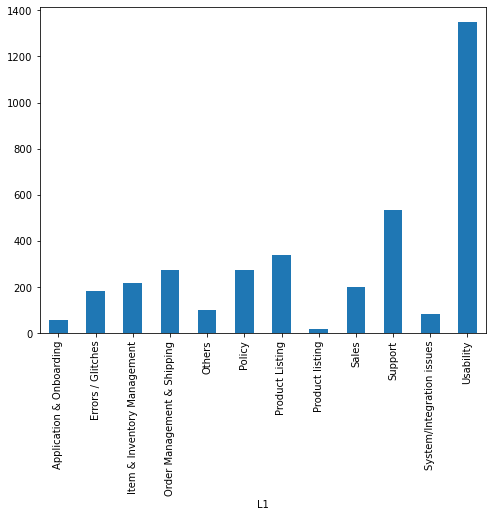

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('L1').Response.count().plot.bar(ylim=0)
plt.show()

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Response).toarray()
labels = df.category_id
features.shape

(3619, 912)

In [9]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for L1, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(L1))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Application & Onboarding':
  . Most correlated unigrams:
       . onboarding
       . account
  . Most correlated bigrams:
       . difficult set
       . seller account
# 'Errors / Glitches':
  . Most correlated unigrams:
       . glitches
       . bugs
  . Most correlated bigrams:
       . needs work
       . lot bugs
# 'Item & Inventory Management':
  . Most correlated unigrams:
       . delete
       . inventory
  . Most correlated bigrams:
       . inventory updates
       . update inventory
# 'Order Management & Shipping':
  . Most correlated unigrams:
       . shipping
       . app
  . Most correlated bigrams:
       . integrated shipping
       . seller app
# 'Others':
  . Most correlated unigrams:
       . forced
       . started
  . Most correlated bigrams:
       . 3rd party
       . just started
# 'Policy':
  . Most correlated unigrams:
       . returns
       . return
  . Most correlated bigrams:
       . return policy
       . buy box
# 'Product Listing':
  . Most corr

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['Response'], df['L1'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [12]:
print(clf.predict(count_vect.transform(["Poor seller support"])))

['Support']


In [13]:
print(clf.predict(count_vect.transform(["System runs very slow, not always accurate"])))

['Usability']


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

In [15]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

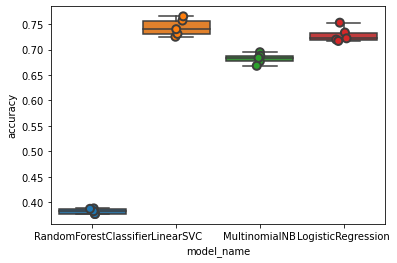

In [16]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [17]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.743575
LogisticRegression        0.728929
MultinomialNB             0.682229
RandomForestClassifier    0.382427
Name: accuracy, dtype: float64

In [18]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

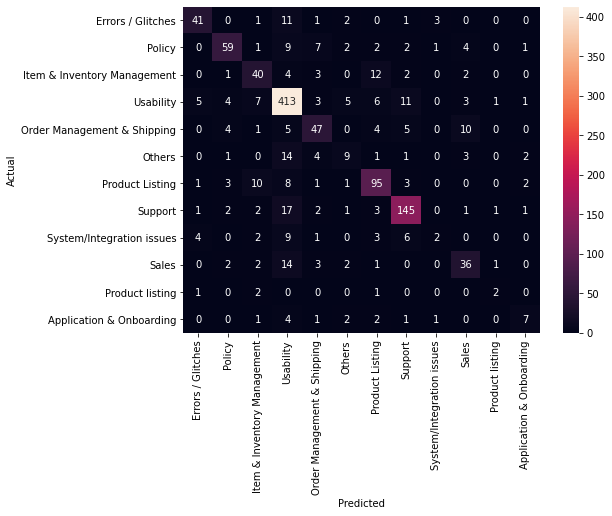

In [19]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.L1.values, yticklabels=category_id_df.L1.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [20]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.68      0.73        60
           1       0.78      0.67      0.72        88
           2       0.58      0.62      0.60        64
           3       0.81      0.90      0.85       459
           4       0.64      0.62      0.63        76
           5       0.38      0.26      0.31        35
           6       0.73      0.77      0.75       124
           7       0.82      0.82      0.82       176
           8       0.29      0.07      0.12        27
           9       0.61      0.59      0.60        61
          10       0.40      0.33      0.36         6
          11       0.50      0.37      0.42        19

    accuracy                           0.75      1195
   macro avg       0.61      0.56      0.58      1195
weighted avg       0.74      0.75      0.74      1195

